In [14]:
%cd "~/moses-incons-pen-xp"
%load_ext autoreload
%autoreload 2


/home/xabush/moses-incons-pen-xp
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys
sys.path.append("/usr/local/lib/python3.8/dist-packages")


In [15]:
import cvxpy as cp
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import math
from sklearn.model_selection import train_test_split
from datetime import datetime
from notebooks.manifold_reg.util import *

In [18]:
def run_experiment(G, n_sim, l1_vals, l2_vals, val_tf, gn_data=generate_data_v2):
    assert l1_vals.shape[0] == l2_vals.shape[0]
    train_errs = np.zeros((n_sim))
    test_errs = np.zeros((n_sim))
    beta_coef_ = np.zeros((n_sim, len(G)))
    l1_opt = np.zeros(n_sim)
    l2_opt = np.zeros(n_sim)
    L = nx.linalg.laplacianmatrix.normalized_laplacian_matrix(G, weight="weight")

    with open("exp_run.log", "w") as fp:
        for s in range(n_sim):
            # print(f"[{datetime.now()}] - Running SIM {s} ....")
            # fp.write(f"[{datetime.now()}] - Running SIM {s} ....")
            X, _, y = gn_data(200, 10, tf_on=4, val_tf=val_tf, n=200)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
            train_err, test_err, coef, l1_val, l2_val = solve_lasso(X_train, X_test, y_train, y_test, l1_vals, l2_vals, L, fp, n_iter=l1_vals.shape[0])
            train_errs[s] = train_err
            test_errs[s] = test_err
            beta_coef_[s] = coef
            l1_opt[s] = l1_val
            l2_opt[s] = l2_val

        print(f"[{datetime.now()}] - Done")

        return train_errs, test_errs, beta_coef_, l1_opt, l2_opt



def nonzero_coef(betas):
    indx = np.where((betas > 1e-8) | (betas < -1e-8))
    print(indx[0].shape)
    return indx

def calculate_sens_spec(beta_coef):
    beta_true = np.zeros(len(beta_coef))
    beta_true[np.arange(0, 44)] = 1

    idx = nonzero_coef(beta_coef)
    beta_pred = np.zeros(len(beta_coef))
    beta_pred[idx] = 1

    tn, fp, fn, tp = confusion_matrix(beta_true, beta_pred).ravel()


    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    print(f"tp: {tp}, fp: {fp}, fn: {fn}, tp: {tp}")
    return sensitivity, specificity


%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def plot_train_test_errors(train_errors, test_errors, lambd_values):
    plt.plot(lambd_values, train_errors, label="Train error")
    plt.plot(lambd_values, test_errors, label="Test error")
    plt.xscale("log")
    plt.legend(loc="upper left")
    plt.xlabel(r"$\lambda$", fontsize=16)
    plt.title("Mean Squared Error (MSE)")
    plt.show()

In [8]:
import networkx as nx

G = nx.Graph()
for i in range(1, 201):
    G.add_node(f"TF{i}")
    for g in range(1, 11):
        G.add_node(f"TF{i}g{g}")
        G.add_edge(f"TF{i}", f"TF{i}g{g}", weight=0.7)

len(G)

2200

In [19]:
train_errs, test_errs, beta_coef_, l1_opt, l2_opt = run_experiment(G, 5, np.logspace(-2, 1, 10), np.logspace(-2, 3, 10), [5, 5, 5 ,5])

/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Encountered solver error for l1 - 4.6415888336127775, l2 - 77.42636826811278. Moving on...
Encountered solver error for l1 - 4.6415888336127775, l2 - 1000.0. Moving on...
Encountered solver error for l1 - 10.0, l2 - 278.2559402207126. Moving on...
Encountered solver error for l1 - 10.0, l2 - 1000.0. Moving on...
(9, 5)
Encountered solver error for l1 - 4.6415888336127775, l2 - 1000.0. Moving on...
(9, 6)
Encountered solver error for l1 - 4.6415888336127775, l2 - 1000.0. Moving on...
Encountered solver error for l1 - 10.0, l2 - 1000.0. Moving on...
(9, 6)
Encountered solver error for l1 - 4.6415888336127775, l2 - 1000.0. Moving on...
Encountered solver error for l1 - 10.0, l2 - 278.2559402207126. Moving on...
Encountered solver error for l1 - 10.0, l2 - 1000.0. Moving on...
(9, 5)
Encountered solver error for l1 - 4.6415888336127775, l2 - 77.42636826811278. Moving on...
Encountered solver error for l1 - 4.6415888336127775, l2 - 1000.0. Moving on...
Encountered solver error for l1 - 10.0

In [21]:
np.mean(test_errs)

72.9477928249843

In [20]:
test_idx = np.unravel_index(np.argmin(test_errs), test_errs.shape)
print(f"Least MSE on test: {test_errs[test_idx]}")
beta_coef_[test_idx]

Least MSE on test: 61.81031281117777


array([ 5.13942183e+00,  1.60948911e+00,  1.72737034e+00, ...,
       -3.66612074e-09, -1.62171915e-01, -2.60146949e-10])

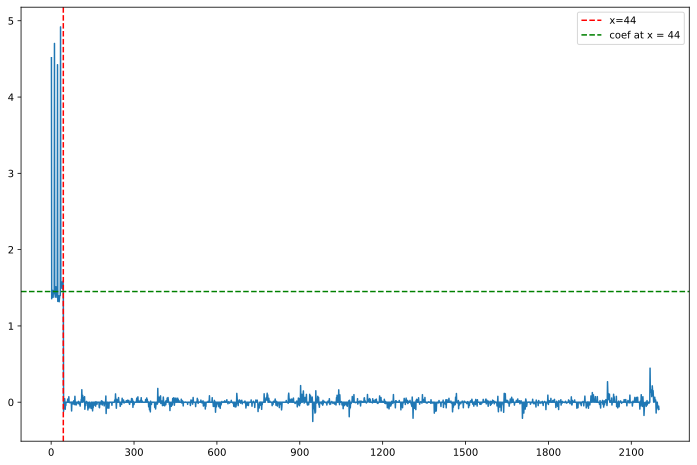

In [631]:
from matplotlib.pyplot import figure
fig = figure(figsize=(12, 8))
plt.plot(np.arange(1, 2201), beta_coef_[test_idx], figure=fig)
plt.xticks(np.arange(0, 2201, 300))
plt.axvline(x=44, color='red', linestyle='--', label="x=44")
plt.axhline(y=beta_coef_[test_idx][43], linestyle='--', label="coef at x = 44", color="green")
plt.legend()
plt.show()


In [564]:
print(f"Optimal lambda_1 - {l1_opt[test_idx]}\nOptimal lambda_2 - {l2_opt[test_idx]}")

Optimal lambda_1 - 1.0
Optimal lambda_2 - 10.0


In [22]:
val_tf_v2 = [5, -5, 5, -5]
train_errs_v2, test_errs_v2, beta_coef__v2, l1_opt_v2, l2_opt_v2 = run_experiment(G, 5, np.logspace(-2, 1, 10), np.zeros(10), [5, 5, 5 ,5])

/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


(7, 0)
(9, 0)
(6, 0)
(9, 0)
(0, 0)
[2022-01-24 22:10:00.038212] - Done


In [23]:
test_idx_v2 = np.unravel_index(np.argmin(test_errs_v2), test_errs_v2.shape)
print(f"Least MSE on test: {test_errs_v2[test_idx_v2]}")
beta_coef__v2[test_idx_v2]

Least MSE on test: 86.23042962912768


array([ 1.28928593e+01,  6.37762464e-11,  1.09099532e-10, ...,
       -2.76161122e-11,  3.41241543e-12, -1.95365448e-11])

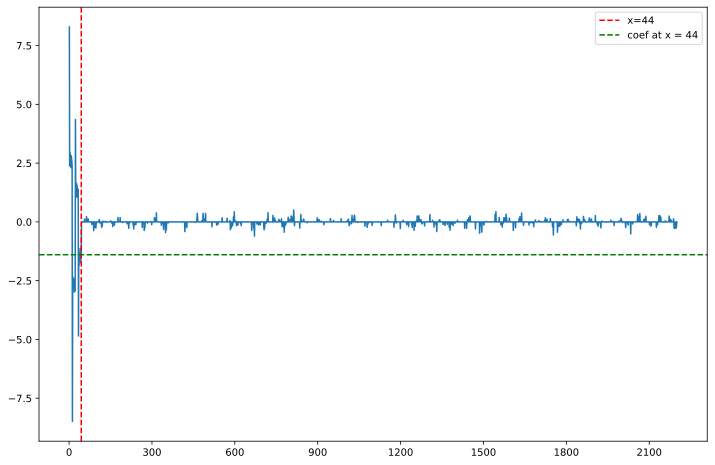

In [9]:
from matplotlib.pyplot import figure
fig = figure(figsize=(12, 8))
plt.plot(np.arange(1, 2201), beta_coef__v2[test_idx_v2], figure=fig)
plt.xticks(np.arange(0, 2201, 300))
plt.axvline(x=44, color='red', linestyle='--', label="x=44")
plt.axhline(y=beta_coef__v2[test_idx_v2][43], linestyle='--', label="coef at x = 44", color="green")
plt.legend()
plt.show()

In [10]:
print(f"Optimal lambda_1 - {l1_opt_v2[test_idx_v2]}\nOptimal lambda_2 - {l2_opt_v2[test_idx_v2]}")

Optimal lambda_1 - 1.0
Optimal lambda_2 - 1.0


In [20]:
l1_opt_v2

array([0.17782794, 0.17782794, 1.        , 0.56234133, 1.        ,
       0.17782794, 0.56234133, 1.        , 0.56234133, 1.        ,
       0.56234133, 0.31622777, 0.56234133, 1.        , 1.        ,
       1.        , 0.56234133, 1.        , 0.56234133, 0.17782794,
       0.56234133, 0.56234133, 0.31622777, 1.        , 1.        ,
       1.        , 0.17782794, 1.        , 0.31622777, 0.31622777,
       0.56234133, 0.56234133, 0.56234133, 1.        , 0.17782794,
       0.17782794, 1.        , 0.56234133, 1.        , 0.17782794,
       0.31622777, 0.17782794, 0.31622777, 0.56234133, 1.        ,
       0.31622777, 0.56234133, 1.        , 0.56234133, 0.17782794])

In [21]:
l2_opt_v2

array([0.1, 0.1, 1. , 1. , 0.1, 0.1, 1. , 1. , 1. , 1. , 1. , 0.1, 1. ,
       1. , 1. , 1. , 0.1, 1. , 1. , 0.1, 0.1, 1. , 0.1, 0.1, 1. , 0.1,
       0.1, 1. , 0.1, 0.1, 1. , 1. , 1. , 1. , 0.1, 0.1, 1. , 1. , 1. ,
       0.1, 0.1, 0.1, 0.1, 1. , 1. , 0.1, 0.1, 1. , 0.1, 0.1])

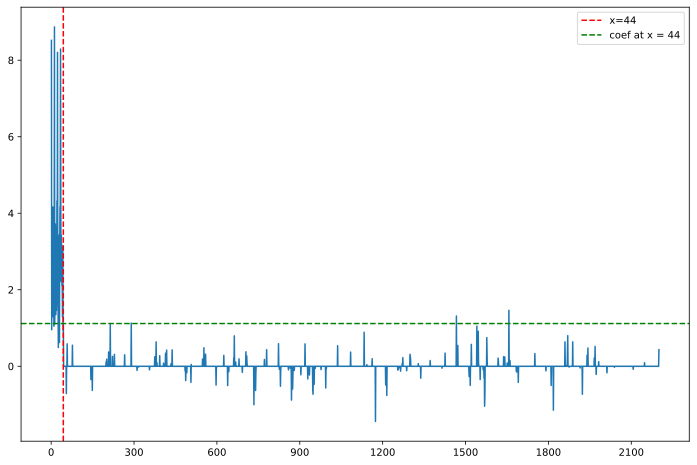

In [22]:
from matplotlib.pyplot import figure
fig = figure(figsize=(12, 8))
plt.plot(np.arange(1, 2201), beta_coef__v2[4], figure=fig)
plt.xticks(np.arange(0, 2201, 300))
plt.axvline(x=44, color='red', linestyle='--', label="x=44")
plt.axhline(y=beta_coef__v2[4][43], linestyle='--', label="coef at x = 44", color="green")
plt.legend()
plt.show()

In [53]:
recall, spec = calculate_sens_spec(beta_coef_[test_idx])
print(f"Sensitivity: {recall}, Specificity: {spec}")

NameError: name 'beta_coef_' is not defined

In [11]:
recall, spec = calculate_sens_spec(beta_coef__v2[test_idx_v2])
print(f"Sensitivity: {recall}, Specificity: {spec}")

(460,)
tp: 44, fp: 416, fn: 0, tp: 44
Sensitivity: 1.0, Specificity: 0.8070500927643784


In [39]:
val_tf_v3 = [5, 5, 5, 5]
train_errs_v3, test_errs_v3, beta_coef__v3, l1_opt_v3, l2_opt_v3 = run_experiment(G, 50, val_tf_v3, n_iter=5, gn_data=generate_data_v2)

(4, 0)
(0, 0)
(4, 0)
(0, 0)
(4, 0)
(0, 0)
(0, 0)
(0, 0)
(4, 0)
(4, 0)
(4, 0)
(4, 0)
(4, 0)
(4, 0)
(0, 0)
(4, 0)
(0, 0)
(4, 0)
(4, 0)
(4, 0)
(4, 0)
(4, 0)
(4, 0)
(0, 0)
(4, 0)
(4, 0)
(4, 0)
(0, 0)
(4, 0)
(4, 0)
(4, 0)
(4, 0)
(4, 0)
(4, 0)
(4, 0)
(4, 0)
(4, 0)
(4, 0)
(4, 0)
(4, 0)
(4, 0)
(4, 0)
(4, 0)
(4, 0)
(4, 0)
(4, 0)
(4, 0)
(4, 0)
(4, 0)
(4, 0)
[2022-01-10 18:41:20.215925] - Done


In [40]:
test_idx_v3 = np.unravel_index(np.argmin(test_errs_v3), test_errs_v3.shape)
print(f"Least MSE on test: {test_errs_v3[test_idx_v3]}")
beta_coef__v3[test_idx_v3]

Least MSE on test: 82.51163199662363


array([ 1.02480849e+01,  1.14857242e+00,  1.61534682e-10, ...,
       -1.35126242e-11, -1.20321019e-11, -1.90973835e-12])

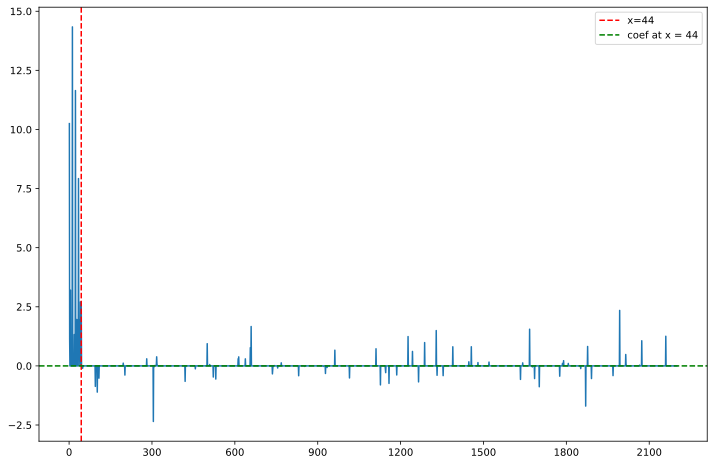

In [42]:
from matplotlib.pyplot import figure
fig = figure(figsize=(12, 8))
plt.plot(np.arange(1, 2201), beta_coef__v3[test_idx_v3], figure=fig)
plt.xticks(np.arange(0, 2201, 300))
plt.axvline(x=44, color='red', linestyle='--', label="x=44")
plt.axhline(y=beta_coef__v3[4][43], linestyle='--', label="coef at x = 44", color="green")
plt.legend()
plt.show()

In [43]:
recall, spec = calculate_sens_spec(beta_coef__v3[test_idx_v3])
print(f"Sensitivity: {recall}, Specificity: {spec}")

(99,)
tp: 20, fp: 79, fn: 24, tp: 20
Sensitivity: 0.45454545454545453, Specificity: 0.9633580705009277


In [44]:
val_tf_v4 = [5, -5, 5, -5]
train_errs_v4, test_errs_v4, beta_coef__v4, l1_opt_v4, l2_opt_v4 = run_experiment(G, 50, val_tf_v4, n_iter=5, gn_data=generate_data_v2)

(4, 0)
(0, 0)
(3, 0)
(2, 0)
(4, 0)
(4, 0)
(4, 0)
(0, 0)
(0, 0)
(4, 0)
(4, 0)
(4, 0)
(4, 0)
(0, 0)
(0, 0)
(4, 0)
(4, 0)
(4, 0)
(4, 0)
(4, 0)
(4, 0)
(4, 0)
(4, 0)
(4, 0)
(4, 0)
(4, 0)
(0, 0)
(4, 0)
(3, 0)
(4, 0)
(4, 0)
(4, 0)
(0, 0)
(4, 0)
(0, 0)
(4, 0)
(4, 0)
(4, 0)
(0, 0)
(4, 0)
(4, 0)
(4, 0)
(4, 0)
(4, 0)
(4, 0)
(4, 0)
(4, 0)
(3, 0)
(4, 0)
(4, 0)
[2022-01-10 19:23:11.957318] - Done


In [45]:
test_idx_v4 = np.unravel_index(np.argmin(test_errs_v4), test_errs_v4.shape)
print(f"Least MSE on test: {test_errs_v4[test_idx_v4]}")
beta_coef__v4[test_idx_v4]

Least MSE on test: 73.26877125427747


array([ 7.60390828e+00,  9.31419129e-12,  6.13526644e-11, ...,
       -1.37315939e-11,  7.26609508e-12, -2.16350501e-12])

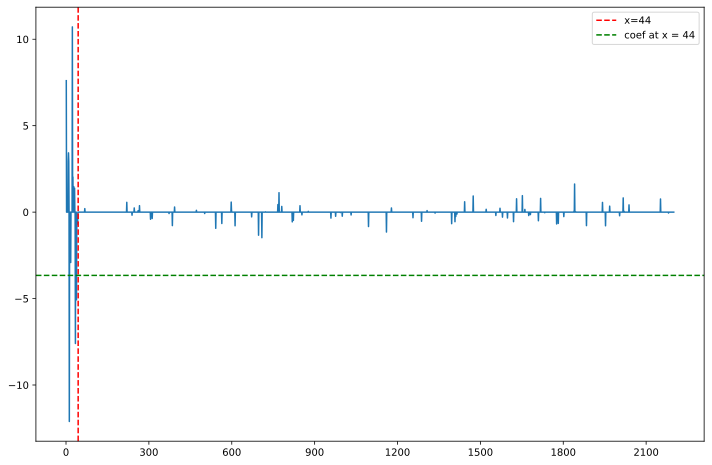

In [46]:
from matplotlib.pyplot import figure
fig = figure(figsize=(12, 8))
plt.plot(np.arange(1, 2201), beta_coef__v4[test_idx_v4], figure=fig)
plt.xticks(np.arange(0, 2201, 300))
plt.axvline(x=44, color='red', linestyle='--', label="x=44")
plt.axhline(y=beta_coef__v4[4][43], linestyle='--', label="coef at x = 44", color="green")
plt.legend()
plt.show()

In [51]:
recall, spec = calculate_sens_spec(beta_coef__v4[test_idx_v4])
print(f"Sensitivity: {recall}, Specificity: {spec}")

(99,)
tp: 18, fp: 81, fn: 26, tp: 18
Sensitivity: 0.4090909090909091, Specificity: 0.962430426716141
